In [1]:
import pandas as pd

## Schema

publisher_id - The publisher ID assigned by Databento, which denotes the dataset and venue.

instrument_id - The numeric instrument ID.

ts_event - The matching-engine-received timestamp expressed as the number of nanoseconds since the UNIX epoch.

price - The order price where every 1 unit corresponds to 1e-9, i.e. 1/1,000,000,000 or 0.000000001.

size - The order quantity.

action - The event action. Always Trade in the TBBO schema. See Action.

side - The side that initiates the event. Can be Ask for a sell aggressor, Bid for a buy aggressor, or None where no side is specified by the original trade.

flags - A bit field indicating event end, message characteristics, and data quality. See Flags.

depth - The book level where the update event occurred.

ts_recv - The capture-server-received timestamp expressed as the number of nanoseconds since the UNIX epoch.

ts_in_delta - The matching-engine-sending timestamp expressed as the number of nanoseconds before ts_recv.

sequence - The message sequence number assigned at the venue.

bid_px_00 - The bid price at the top level. (highest price a buyer is willing to pay)

ask_px_00 - The ask price at the top level. (lowest price a seller is willing to accept)

bid_sz_00 - The bid size at the top level. (number of shares investors are trying to buy)

ask_sz_00 - The ask size at the top level. (number of shares investors are trying to sell)

bid_ct_00 - The number of bid orders at the top level. 

ask_ct_00 - The number of ask orders at the top level.

In [2]:
df = pd.read_csv('data/data.csv')
df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol
0,1688371200660869841,1688371200660704717,1,2,32,T,B,0,194120000000,1,130,165124,303634,193630000000,194120000000,27,27,1,1,AAPL
1,1688371201201402566,1688371201201237816,1,2,32,T,B,0,194110000000,2,130,164750,304724,193900000000,194110000000,5,400,1,1,AAPL
2,1688371201233688992,1688371201233524761,1,2,32,T,B,0,194110000000,8,130,164231,304850,193900000000,194110000000,5,398,1,1,AAPL
3,1688371201317556361,1688371201317392163,1,2,32,T,B,0,194110000000,2,130,164198,305101,193900000000,194110000000,5,390,1,1,AAPL
4,1688371201478520666,1688371201478356044,1,2,32,T,B,0,194000000000,7,130,164622,306430,193900000000,194000000000,5,200,1,1,AAPL


In [3]:
df.shape

(59271, 20)

Technical Indicators used for the project include:

- Trend Indicators:
    1) Moving Averages (MA)
    2) Exponential Moving Averages (EMA)
    3) Ichimoku Cloud (ICH)
    4) Average Directional Index (ADX)
    5) Directional Index (DI)

- Momentum Indicators:
    1) Momentum (MOM)
    2) Rate of Change (ROC)
    3) Commodity Channel Index (CCI)
    4) Moving Average Convergence/Divergence (MACD)
    5) Relative Strength Index (RSI)
    6) Stochastic Oscillator (Stoch)
    
- Volume Indicators:
    1) On Balance Volume (OBV)
    2) Accumulation/Distribution Line (ADL)
    3) OBV Mean

- Volatility Indicators:
    1) Bollinger Bands (BB)
    2) Average True Range (ATR)

- Price Indicators:
    1) Time-Weighted Average Price (TWAP)
    2) VOlume-Weighted Average Price (VWAP)

In [4]:
import talib as ta
import numpy as np

class TechnicalIndicators:
    def __init__(self, df):
        self.df = df
    
    def add_trend_indicators(self):

        # Ichimoku Cloud components (will start from 101st index)
        self.df['conversion_line'], self.df['base_line'] = ta.TEMA(self.df['Close'], timeperiod=9), ta.TEMA(self.df['Close'], timeperiod=26)
        self.df['span_a'] = ((self.df['conversion_line'] + self.df['base_line']) / 2).shift(26)
        self.df['span_b'] = ta.SMA(self.df['Close'], timeperiod=52).shift(26)
        self.df['lagging_span'] = self.df['Close'].shift(-26) # 26 days behind

        # Exponential Moving Average (EMA)
        self.df['EMA'] = ta.EMA(df['Close'], timeperiod=20) # 20-period EMA (from 19th index)

        # Moving Average (MA) for time periods of 50 (short-term trend) and 200 (long-term trend)
        self.df['MA50'] = ta.SMA(df['Close'], timeperiod=50)
        self.df['MA200'] = ta.SMA(df['Close'], timeperiod=200)

        # Average Directional Index (ADX)
        # since ADX is calculated using +DI and -DI, let's calculate those values as well (although these values are calculated internally while calculating ADX, it's still nice to have these values for future visualizations or analysis)
        self.df['ADX'] = ta.ADX(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14) #from 28th index
        self.df['+DI'] = ta.PLUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14) #from 14th index
        self.df['-DI'] = ta.MINUS_DI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14) #from 14th index
    
    def add_momentum_indicators(self):

        # Momentum
        self.df['Momentum'] = ta.MOM(self.df['Close'], timeperiod=10) #from 10th index

        # Rate Of Change (ROC)
        self.df['ROC'] = ta.ROC(self.df['Close'], timeperiod=10)

        # Commodity Channel Index (CCI)
        self.df['CCI'] = ta.CCI(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14)

        # MACD
        self.df['MACD'], self.df['MACD_signal'], self.df['MACD_hist'] = ta.MACD(self.df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

        # RSI
        self.df['RSI'] = ta.RSI(self.df['Close'], timeperiod=14)

        # Stochastic Oscillator
        self.df['Stoch_k'], self.df['Stoch_d'] = ta.STOCH(self.df['High'], self.df['Low'], self.df['Close'], fastk_period=14, slowk_period=3, slowd_period=3)

    def add_volume_indicators(self):
        
        # On Balance Volume
        self.df['OBV'] = ta.OBV(self.df['Close'], self.df['Volume'])

        # Accumulation/Distribution Line (ADL)
        self.df['ADL'] = ta.AD(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'])

    def add_volatility_indicators(self):
        
        # Bollinger Bands (BB)
        self.df['Upper_BB'], self.df['Middle_BB'], self.df['Lower_BB'] = ta.BBANDS(self.df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

        # Average True Range (ATR)
        self.df['ATR'] = ta.ATR(self.df['High'], self.df['Low'], self.df['Close'], timeperiod=14)

    def add_price_indicators(self):
        '''
        Since the talib doesn't have a function to calculate TWAP and VWAP, I will be calculating them manually
        '''

        # Time-Weighted Average Price (TWAP) - SUM(Price * Time) / SUM(Time)
        self.df['Timestamp'] = pd.to_datetime(self.df['ts_event'])
        # calculating time differences in seconds
        self.df['Time'] = self.df['Timestamp'].diff().dt.total_seconds()
        # calculating weighted closed prices
        self.df['Weighted_Close'] = df['Close'] * df['Time']
        # calculating TWAP
        self.df['TWAP'] = self.df['Weighted_Close'].cumsum() / self.df['Time'].cumsum()

        # Volume-Weighted Average PRice (VWAP) - SUM(Price * Volume) / SUM(Volume)
        self.df['VWAP'] = (self.df['Close'] * self.df['Volume']).cumsum() / self.df['Volume'].cumsum()

    def add_all_indicators(self):
        self.add_trend_indicators()
        self.add_momentum_indicators()
        self.add_volume_indicators()
        self.add_volatility_indicators()
        self.add_price_indicators()
        return self.df


In [5]:
# Creating necessary columns to calculate techincal indicators
df['price'] = df['price'] * 1e-9
df['bid_px_00'] = df['bid_px_00'] * 1e-9
df['ask_px_00'] = df['ask_px_00'] * 1e-9

df['Close'] = df['price']
df['Open'] = df['Close'].shift(1).fillna(df['Close'])
df['Volume'] = df['size']
df['High'] = df[['bid_px_00','ask_px_00']].max(axis=1)
df['Low'] = df[['bid_px_00','ask_px_00']].min(axis=1)

ti = TechnicalIndicators(df)
df_with_indicators = ti.add_all_indicators()


In [6]:
pd.set_option('display.max_columns', None)

market_features_df = df_with_indicators[199:].reset_index(drop=True)
# market_features_df
market_features_df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,Close,Open,Volume,High,Low,conversion_line,base_line,span_a,span_b,lagging_span,EMA,MA50,MA200,ADX,+DI,-DI,Momentum,ROC,CCI,MACD,MACD_signal,MACD_hist,RSI,Stoch_k,Stoch_d,OBV,ADL,Upper_BB,Middle_BB,Lower_BB,ATR,Timestamp,Time,Weighted_Close,TWAP,VWAP
0,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,2,0,166619,613573,194.00,194.17,853,50,6,1,AAPL,194.00,194.01,2,194.17,194.00,194.027891,194.024564,194.102973,194.151346,194.05,194.038516,194.0784,194.11920,59.901979,7.029446,9.844471,0.00,0.000000,54.545455,-0.010144,-0.013576,0.003433,39.207231,1.568627e+01,48.366013,-4698.0,-4697.734161,194.097838,194.0330,193.968162,0.094418,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081814
1,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,8,130,166619,613574,194.00,194.17,851,50,5,1,AAPL,194.00,194.00,8,194.17,194.00,194.012985,194.018694,194.104036,194.148846,194.04,194.034848,194.0758,194.11860,56.814888,6.174306,8.646880,0.00,0.000000,47.381865,-0.012113,-0.013284,0.001171,39.207231,1.960784e+00,22.222222,-4698.0,-4705.734161,194.093523,194.0295,193.965477,0.099817,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081747
2,1688371628277860493,1688371628277695844,1,2,32,T,A,0,194.00,96,130,164649,613576,194.00,194.17,843,50,5,1,AAPL,194.00,194.00,96,194.17,194.00,194.003783,194.013766,194.070098,194.144231,194.01,194.031529,194.0732,194.11805,53.948304,5.459113,7.645281,0.00,0.000000,41.374570,-0.013518,-0.013330,-0.000187,39.207231,3.671137e-14,5.882353,-4698.0,-4801.734161,194.088418,194.0260,193.963582,0.104830,2023-07-03 08:07:08.277695844,0.001214,0.235556,194.159453,194.080956
3,1688371628500840454,1688371628500675770,1,2,32,T,A,0,194.07,2,130,164684,613843,194.07,194.17,2,150,1,2,AAPL,194.07,194.00,2,194.17,194.07,194.032588,194.024091,194.043014,194.139423,194.01,194.035193,194.0722,194.11785,51.286475,4.853650,6.797352,0.07,0.036082,187.890137,-0.008880,-0.012440,0.003560,56.163576,1.372549e+01,5.228758,-4696.0,-4803.734161,194.088418,194.0260,193.963582,0.109485,2023-07-03 08:07:08.500675770,0.222980,43.273714,194.159407,194.080954
4,1688371640349690276,1688371640349525673,1,2,32,T,N,0,194.11,1,130,164603,622059,194.04,194.17,7,550,1,3,AAPL,194.11,194.07,1,194.17,194.04,194.070797,194.041291,194.024295,194.134615,194.07,194.042318,194.0720,194.11785,49.726474,4.447436,8.159829,0.04,0.020611,157.095710,-0.001955,-0.010343,0.008389,62.585521,3.529412e+01,16.339869,-4695.0,-4803.657238,194.100805,194.0290,193.957195,0.110950,2023-07-03 08:07:20.349525673,11.848850,2299.980255,194.158075,194.080956


In [240]:
features = [
    "Close",
    "Open",
    "Volume",
    "High",
    "Low",
    "conversion_line",
    "base_line",
    "span_a",
    "span_b",
    "EMA",
    "ADX",
    "+DI",
    "-DI",
    "Momentum",
    "ROC",
    "CCI",
    "MACD",
    "MACD_signal",
    "MACD_hist",
    "RSI",
    "Stoch_k",
    "Stoch_d",
    "OBV",
    "ADL",
    "Upper_BB",
    "Middle_BB",
    "Lower_BB",
    "ATR",
    "Time",
    "Weighted_Close",
    "TWAP",
    "VWAP"
]

In [171]:
len(features)

32

Checking for any clusters or patterns in the data using PCA and t-SNE

If any clusters or patterns are found, we can then label our data using clustering

In [13]:
# PCA to identify important features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
market_features_df_scaled = scaler.fit_transform(market_features_df[features])

In [11]:
# PCA
from sklearn.decomposition import PCA
pca  = PCA(n_components=2) # reduced to 2 dimensions
pca_data = pca.fit_transform (market_features_df_scaled)

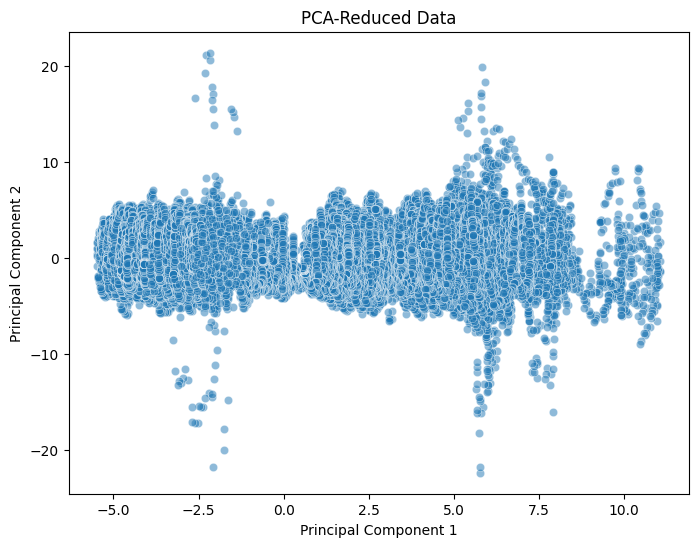

In [13]:
# Plot the PCA-reduced data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], alpha=0.5)
plt.title('PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [14]:
# Applying t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)  # reduce to 2 dimensions
tsne_data = tsne.fit_transform(market_features_df_scaled)



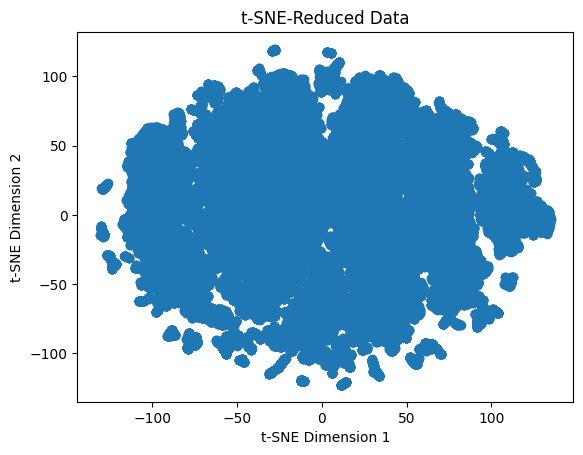

In [15]:
# Plot the t-SNE-reduced data
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE-Reduced Data')
plt.show()

Clearly no clusters are found with PCA and t-SNE, so there is no point of using clustering to label the data. Instead we will use available technical indicators to label our data manually.

### Technical Indicators to Label the data

In [7]:
# 0 - HOLD, 1 - BUY, 2 - SELL
def label_data(row):
    if (row['Close'] > row['MA50'] and row['Close'] > row['MA200']) or row['RSI'] < 30:
        return 1
    elif (row['Close'] < row['MA50'] and row['Close'] < row['MA200']) or row['RSI'] > 70:
        return 2
    else:
        return 0

market_features_df['label'] = market_features_df.apply(label_data, axis=1)
market_features_df = market_features_df.reset_index(drop=True)
market_features_df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,symbol,Close,Open,Volume,High,Low,conversion_line,base_line,span_a,span_b,lagging_span,EMA,MA50,MA200,ADX,+DI,-DI,Momentum,ROC,CCI,MACD,MACD_signal,MACD_hist,RSI,Stoch_k,Stoch_d,OBV,ADL,Upper_BB,Middle_BB,Lower_BB,ATR,Timestamp,Time,Weighted_Close,TWAP,VWAP,label
0,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,2,0,166619,613573,194.00,194.17,853,50,6,1,AAPL,194.00,194.01,2,194.17,194.00,194.027891,194.024564,194.102973,194.151346,194.05,194.038516,194.0784,194.11920,59.901979,7.029446,9.844471,0.00,0.000000,54.545455,-0.010144,-0.013576,0.003433,39.207231,1.568627e+01,48.366013,-4698.0,-4697.734161,194.097838,194.0330,193.968162,0.094418,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081814,2
1,1688371628276648256,1688371628276481637,1,2,32,T,A,0,194.00,8,130,166619,613574,194.00,194.17,851,50,5,1,AAPL,194.00,194.00,8,194.17,194.00,194.012985,194.018694,194.104036,194.148846,194.04,194.034848,194.0758,194.11860,56.814888,6.174306,8.646880,0.00,0.000000,47.381865,-0.012113,-0.013284,0.001171,39.207231,1.960784e+00,22.222222,-4698.0,-4705.734161,194.093523,194.0295,193.965477,0.099817,2023-07-03 08:07:08.276481637,0.000000,0.000000,194.159454,194.081747,2
2,1688371628277860493,1688371628277695844,1,2,32,T,A,0,194.00,96,130,164649,613576,194.00,194.17,843,50,5,1,AAPL,194.00,194.00,96,194.17,194.00,194.003783,194.013766,194.070098,194.144231,194.01,194.031529,194.0732,194.11805,53.948304,5.459113,7.645281,0.00,0.000000,41.374570,-0.013518,-0.013330,-0.000187,39.207231,3.671137e-14,5.882353,-4698.0,-4801.734161,194.088418,194.0260,193.963582,0.104830,2023-07-03 08:07:08.277695844,0.001214,0.235556,194.159453,194.080956,2
3,1688371628500840454,1688371628500675770,1,2,32,T,A,0,194.07,2,130,164684,613843,194.07,194.17,2,150,1,2,AAPL,194.07,194.00,2,194.17,194.07,194.032588,194.024091,194.043014,194.139423,194.01,194.035193,194.0722,194.11785,51.286475,4.853650,6.797352,0.07,0.036082,187.890137,-0.008880,-0.012440,0.003560,56.163576,1.372549e+01,5.228758,-4696.0,-4803.734161,194.088418,194.0260,193.963582,0.109485,2023-07-03 08:07:08.500675770,0.222980,43.273714,194.159407,194.080954,2
4,1688371640349690276,1688371640349525673,1,2,32,T,N,0,194.11,1,130,164603,622059,194.04,194.17,7,550,1,3,AAPL,194.11,194.07,1,194.17,194.04,194.070797,194.041291,194.024295,194.134615,194.07,194.042318,194.0720,194.11785,49.726474,4.447436,8.159829,0.04,0.020611,157.095710,-0.001955,-0.010343,0.008389,62.585521,3.529412e+01,16.339869,-4695.0,-4803.657238,194.100805,194.0290,193.957195,0.110950,2023-07-03 08:07:20.349525673,11.848850,2299.980255,194.158075,194.080956,0


In [8]:
market_features_df['label'].value_counts()

label
1    36335
2    13307
0     9430
Name: count, dtype: int64

There is clear class imbalance in the data. We'll compare the model's performance with and without handling class imbalance later.

## Model Training

In [243]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [16]:
# Let's separate our features and labels
X = market_features_df[features]
y = market_features_df['label']

Since there are a lot of features in our dataset, let's find the important ones using the four methods below:

1) Correlation Analysis
2) Mutual Information
3) Random Forest - Feature Importance
4) Permutation Feature Importance

In [18]:
# Method 1
corr_matrix = X.corrwith(y)
important_features = corr_matrix.abs().sort_values(ascending=False).head(10)
important_features

MACD_signal    0.140545
MACD           0.106421
MACD_hist      0.084107
ADX            0.048822
+DI            0.047818
TWAP           0.041809
OBV            0.035889
VWAP           0.029110
-DI            0.023737
CCI            0.020494
dtype: float64

In [19]:
# Method 2
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)
important_features = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False).head(5)
important_features

RSI         0.744644
TWAP        0.716799
VWAP        0.690504
OBV         0.622601
Lower_BB    0.173574
dtype: float64

Mutual information between two variables (in this case, each of the features and target variable) ranges between 0 and 1. 0 - 0.5 means that there is a weak dependence of features on target variable amd > 0.5 means that the dependence is strong. 

In [32]:
# Method 3
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
important_features = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
important_features

RSI            0.244547
MACD_signal    0.100604
MACD           0.086353
ADX            0.036922
MACD_hist      0.034987
Stoch_d        0.028339
Stoch_k        0.027775
ADL            0.027528
VWAP           0.027356
OBV            0.027257
dtype: float64

In [33]:
# Method 4
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
importances = permutation_importance(rf, X, y, n_repeats=10)
important_features = pd.Series(importances.importances_mean, index=X.columns).sort_values(ascending=False).head(10)
important_features

RSI            0.347021
MACD_signal    0.049983
ADX            0.013150
MACD_hist      0.012707
MACD           0.010851
-DI            0.000855
CCI            0.000719
ADL            0.000488
ROC            0.000411
+DI            0.000405
dtype: float64

From the above 4 methods it is clear that RSI, TWAP, VWAP, and OBV have highest mutual information scores, that means, these features have strongly dependence on the target variable. In the rest of the methods, no other feature seems to have a strong relationship with the target variable. Hence, while training we will assign higher weights to the abovementioned features than the other ones. 

Note: This is a trial and error approach, meaning, we will compare the model's performance with and without adding weights to the 4 features mentioned above.

### Training Informer Model

In [175]:
# Classification Head with MLP
class ClassificationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(128,128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128,3)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        return self.softmax(self.linear2(x))

In [275]:
from transformers import TimeSeriesTransformerModel
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, num_classes, pretrained_model='huggingface/time-series-transformer-tourism-monthly'):
        super().__init__() # this line is, for the current class (TimeSeriesTransformer()) to inherit the parent class (nn.Module)
        self.num_features = num_features

        # loading pre-trained TST model
        self.tst = TimeSeriesTransformerModel.from_pretrained(pretrained_model)

        # Freezing the transformer parameters to avoid overfitting and for many other reasons (explained in the documentation)
        for param in self.tst.parameters():
            param.requires_grad = False
        
        # Adding a classification head on top of the pre-trained weights
        self.classifier = ClassificationHead()

    def forward(self, past_values, past_time_features, future_values=None, future_time_features=None, static_categorical_features=None, static_real_features=None):
        
        print(past_values.shape)
        print(past_time_features.shape)

        outputs = self.tst(
            past_values=past_values,
            past_time_features=past_time_features,
            # past_observed_mask=past_time_features,
            past_observed_mask=torch.ones_like(past_values),  # lets assume all past values are observed
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            future_values=future_values,
            future_time_features=future_time_features,
        )

        # using the last hidden state for classification
        last_hidden_state = outputs.last_hidden_state[:,-1,:]

        logits = self.classifier(last_hidden_state)
        return logits


In [284]:
from torch.utils.data import Dataset, DataLoader
class PrepareDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        past_values = self.data[index:index+self.seq_length, :-1] # features
        past_time_features = np.arange(self.seq_length).reshape(-1, 1) # timestamp
        future_values = self.data[index+self.seq_length:index+self.seq_length+1, :-1]
        future_time_features = self.data[index+self.seq_length:index+self.seq_length+1, -1:]
        target = self.data[index+self.seq_length, -1] # target

        return {
            'past_values': torch.FloatTensor(past_values).unsqueeze(1),
            'past_time_features': torch.FloatTensor(past_time_features),
            'future_values': torch.FloatTensor(future_values),
            'future_time_features': torch.FloatTensor(future_time_features),
            'target': torch.LongTensor([target])
        }

In [277]:
from sklearn.preprocessing import StandardScaler
def scale_data(df, features):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])
    # scaled_data = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
    return scaled_data

In [278]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        # batch['past_time_features'] = batch['past_time_features'].unsqueeze(1)
        outputs = model(
            past_values = batch['past_values'].to(device),
            past_time_features=batch['past_time_features'].to(device)
            # future_values=batch['future_values'].to(device),
            # future_time_features=batch['future_time_features'].to(device)
            # target=batch['target'].to(device)
        )
        loss = criterion(outputs, batch['target'].squeeze().to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [279]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                past_values = batch['past_values'].to(device),
                past_time_features=batch['past_time_features'].to(device)
                # future_values=batch['future_values'].to(device),
                # future_time_features=batch['future_time_features'].to(device)
            )
            loss = criterion(outputs, batch['target'].squeeze().to(device))
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch['target'].size(0)
            correct += (predicted == batch['target'].squeeze().to(device)).sum().item()
    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [280]:
from sklearn.model_selection import train_test_split
import torch.optim as optim


def fine_tune_tst(data, features, target, time_column, seq_length, batch_size=16, epochs=10, learning_rate=0.001):
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    train_dataset = PrepareDataset(train_data, seq_length)
    val_dataset = PrepareDataset(val_data, seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)


    # for batch in train_loader:
        # print(batch['past_values'].shape)
    device = torch.device('cpu')
    model = TimeSeriesTransformer(len(features), num_classes=3)

    # fine-tuning the classification head
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return model

In [9]:
market_features_df.to_csv('market_df.csv')

In [285]:
features = ["Close", "Open", "Volume", "High", "Low", "conversion_line", "base_line", "span_a", "span_b", "EMA", "ADX", "+DI", "-DI", "Momentum", "ROC", "CCI", "MACD", "MACD_signal", "MACD_hist", "RSI", "Stoch_k", "Stoch_d", "OBV", "ADL", "Upper_BB", "Middle_BB", "Lower_BB", "ATR", "Weighted_Close", "TWAP", "VWAP"]
target = 'label'
time_column = 'Timestamp'
seq_length = 10

data = scale_data(market_features_df, features)
market_features_df['Timestamp'] = pd.to_datetime(market_features_df['Timestamp']).apply(lambda x: x.timestamp())
timestamp = market_features_df['Timestamp'].to_numpy()
labels = market_features_df['label'].astype(float).to_numpy()
data = np.column_stack((data, labels))

# # df = pd.concat([scale_data(market_features_df, features), market_features_df[['Timestamp','label']]], axis=1)

fine_tune_tst(data, features, target, time_column, seq_length)

torch.Size([16, 10, 1, 31])
torch.Size([16, 10, 1])


RuntimeError: expand(torch.FloatTensor{[16, 1, 2, 1, 31]}, size=[-1, 0, -1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (5)

In [273]:
np.arange(10).reshape(-1, 1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [52]:
data[:, -1]

array([2.0, 2.0, 2.0, ..., 0.0, 1.0, 1.0], dtype=object)